* Transformers is all you need

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


## Importing dependencies

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import nltk

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
# sns.set_style("whitegrid")
# sns.despine()
# plt.style.use("seaborn-whitegrid")
# plt.rc("figure", autolayout=True)
# plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Loading Data and splitting it to train and test

In [4]:
from datasets import load_dataset

bbc_news = load_dataset("gopalkalpande/bbc-news-summary")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/gopalkalpande--bbc-news-summary-2a01b492fd0ba579/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
bbc_news = bbc_news['train'].train_test_split(test_size=0.2,shuffle=True)
bbc_news

DatasetDict({
    train: Dataset({
        features: ['File_path', 'Articles', 'Summaries'],
        num_rows: 1779
    })
    test: Dataset({
        features: ['File_path', 'Articles', 'Summaries'],
        num_rows: 445
    })
})

## visualizing data

In [6]:
bbc_news['train'][0]

{'File_path': 'entertainment',
 'Articles': 'Brit awards for Devon music acts..Devon singer Joss Stone and rock band Muse won coveted Brit awards during the event\'s 25th anniversary...Seventeen-year-old Stone, from near Cullumpton, won two awards: best British female act, and best urban act out of three award nominations. Muse, whose members met in south Devon, beat Franz Ferdinand, Jamie Cullum, Kasabian and The Libertines for best British live act. The band has sold about two million records worldwide...After beating Amy Winehouse, Jamelia, Natasha Bedingfield and PJ Harvey to the best British female prize, Joss Stone said: "I don\'t know what to say. I don\'t like doing this at all. I\'d like to thank my family for being really supportive and everybody that made my record with me." "I don\'t even know what to do right now. Thank you all you guys for voting for me, I feel sick right now." Viewers of digital music TV channel MTV Base voted Stone the winner in the best urban act categ

<Axes: ylabel='count'>

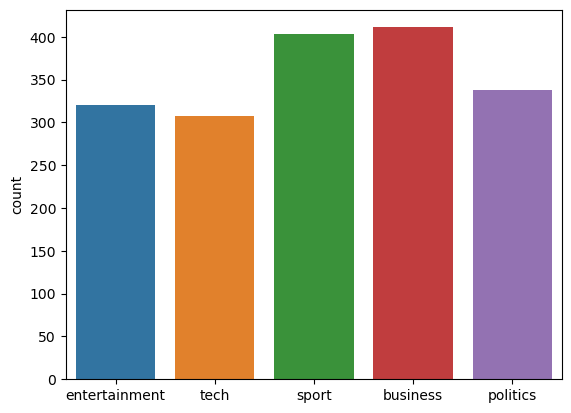

In [7]:
category_train = bbc_news['train']['File_path']
sns.countplot(x=category_train)

<Axes: ylabel='count'>

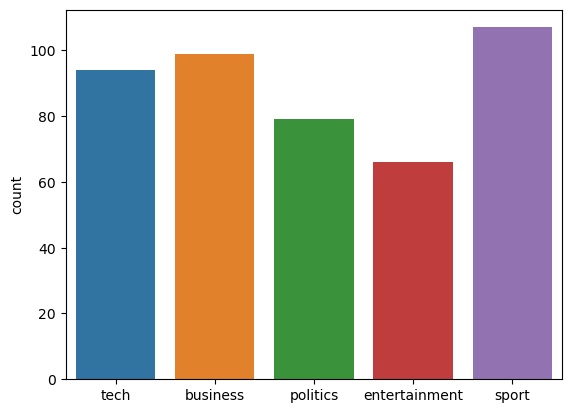

In [8]:
category_test = bbc_news['test']['File_path']
sns.countplot(x=category_test)

In [9]:
bbc_news.set_format(type='pandas')
df_train = bbc_news['train'][:]
df_test = bbc_news['test'][:]

## Preprocessing dataset

In [10]:
import re
import nltk
nltk.download('punkt')
!pip install contractions
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.tokenize import sent_tokenize
from datasets import Dataset,DatasetDict
def remove_stopwords(text):
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    processed_text = [word for word in words if word not in stopwords.words('english')]
#     print(processed_text)
    processed_text = [ lemmatizer.lemmatize(word) for word in processed_text]
#     print(processed_text)
    return ' '.join(processed_text)
def pre_process_df(df1):
    df = df1.copy()
    prefix = "summarize: "
    for col in ['Articles']:
        df[col] = df1[col].apply(lambda x: prefix+x)
        df[col] = df[col].apply(lambda x: contractions.fix(x))
        df[col] = df[col].apply(str.lower)
        df[col] = df[col].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ' , x))
        df[col] = df[col].apply(lambda x: remove_stopwords(x))
        df[col] = df[col].apply(lambda x: re.sub(' +', ' ', x))
    return df
bbc_news_train = pre_process_df(df_train)
bbc_news_test = pre_process_df(df_test)
ds_dict = {'train' : Dataset.from_pandas(bbc_news_train),
           'test' : Dataset.from_pandas(bbc_news_test)}
bbc_news = DatasetDict(ds_dict)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.6 MB/s eta 0:00:00
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citati

In [11]:
bbc_news['train'][10]

{'File_path': 'entertainment',
 'Articles': 'summarize russian film win bbc world prize russian drama return vozvrashchenie named winner bbc four world cinema award film tell story two adolescent boy subjected harsh regime strict father return 10 year absence directed andrey zvyagintsev return previously 2003 golden lion award venice film festival prize presented award ceremony held london thursday hosted jonathan ross winner chosen panel included x file actress gillian anderson critic roger clarke touching void director kevin mcdonald ross presenter bbc one film 2005 also involved deliberation shortlist six film around world drawn panel chose nominee included motorcycle diary zatoichi hero viewer poll saw director zhang yimou martial art epic hero emerge favourite 32 vote cast tragedy struck production return one young star 15 year old vladimir girin drowned lake film scene set winner world cinema award last year french animated feature belleville rendezvous',
 'Summaries': "Russian d

## Converting dataset to format required by our model

In [12]:
from transformers import AutoTokenizer
model_checkpoint = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# sequence = "Using a Transformer network is simple"
# text = tokenizer.tokenize(bbc_news['train'][10]['Articles'])
max_input_length = 512
max_target_length = 100
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["Articles"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["Summaries"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
# def tokenize_function(example):
#     return tokenizer(example["Articles"], example["Summaries"], truncation=True)
tokenized_datasets = bbc_news.map(preprocess_function, batched=True)
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['File_path', 'Articles', 'Summaries', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1779
    })
    test: Dataset({
        features: ['File_path', 'Articles', 'Summaries', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 445
    })
})

In [13]:
tokenized_datasets = tokenized_datasets.remove_columns(bbc_news['train'].column_names)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1779
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 445
    })
})

## Importing pretrained model

In [14]:
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

## Args for finetuning model for our bbc dataset

In [15]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-bbc-lemmatized",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
#     push_to_hub = True
)

## metric for evaluation

In [16]:
import numpy as np
!pip install rouge_score
!pip install evaluate
import evaluate
rouge_score = evaluate.load("rouge")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
#     print(result)
    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=ce25a7a726c4b6f0a12b249a6317425c4c8b53ab4bf2af6db19eac3e10a347b7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━

In [17]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

## Finetuning our model

In [18]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [19]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.143500,0.941490,53.265400,30.973200,34.832800,37.166600
2,0.623000,0.873448,55.645200,33.561400,37.747200,40.103500
3,0.370100,0.933043,56.323800,34.917000,38.613500,40.928200
4,0.231300,1.048905,56.870900,35.561400,39.368700,42.268400
5,0.148200,1.129341,57.247400,35.925000,39.672000,42.565600
6,0.095300,1.247575,58.767500,37.967200,41.515300,44.598000
7,0.060400,1.357133,59.236400,38.554200,42.352100,45.041100
8,0.039400,1.417840,59.174400,38.623500,42.336200,44.895600


TrainOutput(global_step=1784, training_loss=0.337535656804862, metrics={'train_runtime': 3468.4463, 'train_samples_per_second': 4.103, 'train_steps_per_second': 0.514, 'total_flos': 1.3245614216183808e+16, 'train_loss': 0.337535656804862, 'epoch': 8.0})

In [20]:
trainer.evaluate()

{'eval_loss': 1.4178401231765747,
 'eval_rouge1': 59.1744,
 'eval_rouge2': 38.6235,
 'eval_rougeL': 42.3362,
 'eval_rougeLsum': 44.8956,
 'eval_runtime': 192.5206,
 'eval_samples_per_second': 2.311,
 'eval_steps_per_second': 0.291,
 'epoch': 8.0}

## Using saved checkpoint to see how our model works!!!

In [22]:
from transformers import pipeline

hub_model_id = "/kaggle/working/bart-large-cnn-finetuned-bbc-lemmatized/checkpoint-1500"
summarizer = pipeline("summarization", model=hub_model_id)

In [23]:
bbc_news["test"][0]["Articles"]

'summarize microsoft debut security tool microsoft releasing tool clean pc harbouring virus spyware virus fighting program updated monthly precursor microsoft releasing dedicated anti virus software also released software utility help user find remove spyware home computer although initially free thought soon microsoft charging user anti spyware tool anti spyware tool available anti virus utility expected available later month microsoft window operating system long favourite people write computer virus ubiquitous many loophole exploited proved tempting target thought 100 000 virus malicious program existence latest research suggests new variant virus cranked rate 200 per week spyware surreptitious software sneak home computer often without user knowledge benign form bombard user pop advert hijack web browser setting malicious form steal confidential information log every keystroke user make survey shown pc infested spyware research technology firm earthlink webroot revealed 90 window m

In [24]:
def print_summary(idx):
    review = bbc_news["test"][idx]["Articles"]
#     print(idx)
#     title = bbc_news["test"][idx]["File_Path"]
    summary = summarizer(bbc_news["test"][idx]["Articles"])[0]["summary_text"]
    print(f"'>>> Review: {review}'")
# #     print(f"\n'>>> Title: {title}'")
    print(f"\n'>>> Summary: {summary}'")

In [25]:
print_summary(0)

'>>> Review: summarize microsoft debut security tool microsoft releasing tool clean pc harbouring virus spyware virus fighting program updated monthly precursor microsoft releasing dedicated anti virus software also released software utility help user find remove spyware home computer although initially free thought soon microsoft charging user anti spyware tool anti spyware tool available anti virus utility expected available later month microsoft window operating system long favourite people write computer virus ubiquitous many loophole exploited proved tempting target thought 100 000 virus malicious program existence latest research suggests new variant virus cranked rate 200 per week spyware surreptitious software sneak home computer often without user knowledge benign form bombard user pop advert hijack web browser setting malicious form steal confidential information log every keystroke user make survey shown pc infested spyware research technology firm earthlink webroot revealed